In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import pandas as pd

In [3]:
from datasets import load_dataset
from random import sample

text = load_dataset("Hello-SimpleAI/HC3", "all", trust_remote_code=True)
print(text)
train_dataset= text['train']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.49k [00:00<?, ?B/s]

HC3.py:   0%|          | 0.00/9.47k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/39.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/24322 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'human_answers', 'chatgpt_answers', 'source'],
        num_rows: 24322
    })
})


In [4]:
import pandas as pd
df = pd.DataFrame(train_dataset)

In [6]:
# Convert all answers to strings (handle lists and NaN)
human_data = pd.DataFrame({
    'text': df['human_answers'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x)),
    'label': 0
})

chatgpt_data = pd.DataFrame({
    'text': df['chatgpt_answers'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x)),
    'label': 1
})

# Combine datasets and shuffle
combined_df = pd.concat([human_data, chatgpt_data], ignore_index=True)
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

combined_df.head()


,text,label
0,Its a giant phonebook that provides informatio...,0
1,"Pi, denoted by the symbol ""π,"" is a mathematic...",1
2,jumpup has decent explanations but misses quit...,0
3,"Berkshire Hathaway is a large, diversified con...",1
4,The Voyager satellites have several features t...,1


In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from datasets import Dataset
import numpy as np


In [8]:
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from datasets import Dataset
import torch

# Convert the dataframe to a Hugging Face Dataset
hf_dataset = Dataset.from_pandas(combined_df)

# Split into train and test sets
split_data = hf_dataset.train_test_split(test_size=0.2, seed=42)  # 80% train, 20% temp
train_data = split_data['train']
temp_data = split_data['test']

# Further split temp_data into validation and test sets
split_temp = temp_data.train_test_split(test_size=0.5, seed=42)  # 50% val, 50% test from temp_data
val_data = split_temp['train']
test_data = split_temp['test']

# Print sizes to confirm splits
print(f"Train size: {len(train_data)}, Validation size: {len(val_data)}, Test size: {len(test_data)}")

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")


# Tokenization function
def tokenize(batch):
    encoding = tokenizer(batch['text'], padding=True, truncation=True, max_length=256)
    encoding['label'] = batch['label']
    return encoding

# Tokenize each split separately
train_data = train_data.map(tokenize, batched=True)
val_data = val_data.map(tokenize, batched=True)
test_data = test_data.map(tokenize, batched=True)

# Convert to PyTorch-friendly format
train_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])


# Create DataLoaders
def format_dataset(data):
    return torch.utils.data.DataLoader(data, batch_size=64, shuffle=True)

train_loader = format_dataset(train_data)
val_loader = format_dataset(val_data)
test_loader = format_dataset(test_data)

# Confirm DataLoader creation
print(f"Train DataLoader: {len(train_loader)} batches")
print(f"Validation DataLoader: {len(val_loader)} batches")
print(f"Test DataLoader: {len(test_loader)} batches")


Train size: 38915, Validation size: 4864, Test size: 4865


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Map:   0%|          | 0/38915 [00:00<?, ? examples/s]

Map:   0%|          | 0/4864 [00:00<?, ? examples/s]

Map:   0%|          | 0/4865 [00:00<?, ? examples/s]

Train DataLoader: 609 batches
Validation DataLoader: 76 batches
Test DataLoader: 77 batches


In [9]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


In [10]:
# Load the model with a classification head
model = AutoModelForSequenceClassification.from_pretrained("albert-base-v2", num_labels=2)  # 2 labels: human vs ChatGPT


model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",            # Directory to save model checkpoints and logs
    evaluation_strategy="epoch",       # Evaluate at the end of every epoch
    save_strategy="epoch",             # Save the model at the end of every epoch
    learning_rate=2e-5,                # Learning rate
    per_device_train_batch_size=16,    # Batch size for training
    per_device_eval_batch_size=16,     # Batch size for evaluation
    num_train_epochs=3,                # Number of epochs
    weight_decay=0.01,                 # Weight decay for regularization
    logging_dir="./logs",              # Directory for logs
    logging_steps=100,                 # Log every 100 steps
    save_total_limit=2,                # Limit the number of saved checkpoints
    load_best_model_at_end=True,       # Load the best model at the end of training
    metric_for_best_model="accuracy",  # Use accuracy to evaluate the best model
    report_to="none",                  # Disable reporting to external tools like WandB
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [12]:
# Define the compute_metrics function to compute accuracy, precision, recall, and F1 score
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)

    # Calculate accuracy
    accuracy = accuracy_score(labels, predictions)

    # Calculate precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }


In [13]:
# Set up the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


<ipython-input-13-5237f4c01993>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [14]:
# Train the model
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.012300,0.012824,0.998355,0.999593,0.997159,0.998375
2,0.005300,0.004925,0.999178,1.000000,0.998377,0.999188
3,0.000100,0.010490,0.998355,0.999187,0.997565,0.998375


TrainOutput(global_step=7299, training_loss=0.014829451692278195, metrics={'train_runtime': 5349.7331, 'train_samples_per_second': 21.823, 'train_steps_per_second': 1.364, 'total_flos': 1394991944985600.0, 'train_loss': 0.014829451692278195, 'epoch': 3.0})

In [16]:
import torch

# Set the device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Make sure to send your model to the device
model.to(device)


AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertSdpaAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=

In [17]:
from sklearn.metrics import classification_report

# Evaluation function
def evaluate(loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            # Ensure keys are correctly accessed
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)  # 'labels' key must match DataLoader's format

            # Model forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

            # Predictions and labels
            preds = torch.argmax(outputs.logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Ensure function returns predictions and labels
    return all_preds, all_labels


# Evaluate on validation and test sets
val_preds, val_labels = evaluate(val_loader)
test_preds, test_labels = evaluate(test_loader)

print("\nValidation Classification Report:\n", classification_report(val_labels, val_preds))
print("\nTest Classification Report:\n", classification_report(test_labels, test_preds))




Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2400
           1       1.00      1.00      1.00      2464

    accuracy                           1.00      4864
   macro avg       1.00      1.00      1.00      4864
weighted avg       1.00      1.00      1.00      4864


Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2440
           1       1.00      1.00      1.00      2425

    accuracy                           1.00      4865
   macro avg       1.00      1.00      1.00      4865
weighted avg       1.00      1.00      1.00      4865



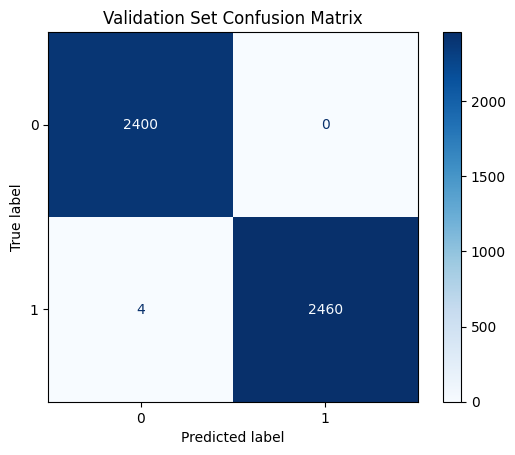

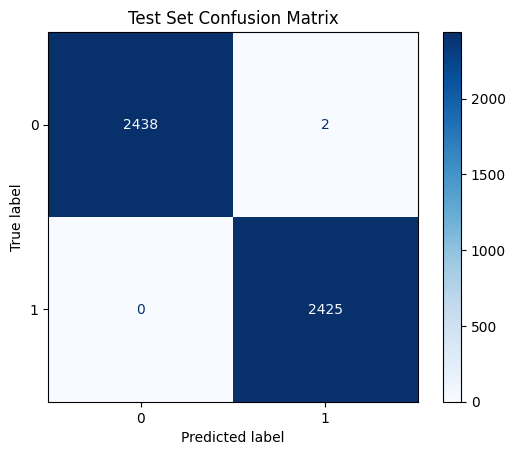

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to plot confusion matrix
def plot_confusion_matrix(labels, preds, title="Confusion Matrix"):
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(title)
    plt.show()

# Plot confusion matrix for validation set
plot_confusion_matrix(val_labels, val_preds, title="Validation Set Confusion Matrix")

# Plot confusion matrix for test set
plot_confusion_matrix(test_labels, test_preds, title="Test Set Confusion Matrix")
